In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [157]:
# System imports
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg
from scipy.interpolate import griddata
import scipy.sparse.linalg
from scipy import linalg
from skimage import color, data, restoration
from ksvd import ApproximateKSVD
from sklearn.linear_model import orthogonal_mp_gram


datadir = "/Users/jho/cs445/final_project/Single-Image-Deblurring/" 

import utils
from utils.utils import gaussian_kernel, matlab_style_gauss2D as gaussian_kernel, matlab_style_gauss2D
from utils.odctdict import odctdict as odctdict

In [158]:
# Credit: sklearn.decomposition.DictionaryLearning
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.DictionaryLearning.html
def update_dict(D, Alpha, I_p_hat):
    n, m = D.shape
    
    gemm, = linalg.get_blas_funcs(('gemm',), (D, Alpha, I_p_hat.T))
    ger, = linalg.get_blas_funcs(('ger',), (D, Alpha))
    nrm2, = linalg.get_blas_funcs(('nrm2',), (D,))
    
    R = I_p_hat.T - np.matmul(D, Alpha.T)
    for k in range(m):
        # R <- 1.0 * U_k * V_k^T + R
        R = ger(1.0, D[:, k], Alpha[:,k], a=R, overwrite_a=True)
        D[:, k] = np.dot(R, Alpha[:,k])
        # Scale k'th atom
        # (U_k * U_k) ** 0.5
        atom_norm = nrm2(D[:, k])
        if atom_norm < 1e-10:
            D[:, k] = np.random.randn(n)
            # Setting corresponding coefs to 0
            Alpha[:,k] = 0.0
            # (U_k * U_k) ** 0.5
            atom_norm = nrm2(D[:, k])
            D[:, k] /= atom_norm
        else:
            D[:, k] /= atom_norm
            # R <- -1.0 * U_k * V_k^T + R
            R = ger(-1.0, D[:, k], Alpha[:,k], a=R, overwrite_a=True)
            
    return D

In [159]:
def get_patch_indices(image, i, j, patch_size):
    if i >= image.shape[0]-patch_size and j >= image.shape[1]-patch_size:
        indices = (image.shape[0]-patch_size, image.shape[0], image.shape[1]-patch_size, image.shape[1])
    elif i >= image.shape[0]-patch_size:
        indices = (image.shape[0]-patch_size, image.shape[0], j, j+patch_size)
    elif j >= image.shape[1]-patch_size:
        indices = (i, i+patch_size, image.shape[1]-patch_size, image.shape[1])
    else:
        indices = (i, i+patch_size, j, j+patch_size)
    return indices

In [160]:
# algorithm from: https://www.math.ucla.edu/~bertozzi/papers/DirectSparseDeblurring.pdf
def direct_sparse(img, D, kernel, num_patches, skip):
    """
    @brief      Direct sparese algoritm by Yifei Lou that solves the deblur problem with
                known kernel. This function also tries to reconstruct the image.
                
    @param      img      blurred image
    @param      D        dictionary
    @param      kernel   kernel
    
    @return     no idea yet
    """
    n, m = D.shape
    kernel_size = kernel.shape[0]
    
    patch_size = int(np.sqrt(n))
    
    I_hat = restoration.richardson_lucy(blur_img, kernel)
    
    patch_index = 0
    I_p_hat = np.zeros((num_patches, n))
    
    B = np.zeros((num_patches, n))
    
    # Get image patches
    for i in range(0, blur_img.shape[0]-patch_size+skip[0], skip[0]):
        for j in range(0, blur_img.shape[1]-patch_size+skip[1], skip[1]):
            indices = get_patch_indices(blur_img, i, j, patch_size)
            patch = blur_img[indices[0]:indices[1], indices[2]:indices[3]]
            
            B[patch_index] = patch.reshape(-1)
            
            I_p_hat[patch_index] = I_hat[indices[0]:indices[1], indices[2]:indices[3]].reshape(-1)
            patch_index += 1
            
    # update dictionary with K-SVD algorithm
    aksvd = ApproximateKSVD(n_components=m)
    D_next = aksvd.fit(I_p_hat).components_
    D_next = D_next.T
    D_hat = cv2.filter2D(D_next, -1, kernel)
    D_hat /= np.linalg.norm(D_hat.reshape(-1), 2)
    

    # Estimate sparse coefficients
    regularization = min(max(n / 10, 1), m)
    gram = D_hat.T@D_hat
    cov = D_hat.T@(B.T)
    norms_squared = np.sqrt((B * B).sum(axis=1))
    Alpha = orthogonal_mp_gram(gram, cov, n_nonzero_coefs=int(regularization), norms_squared=norms_squared, copy_Xy = False)
    Alpha = Alpha.T
    
    
    s = 5
    unblur_img = np.zeros(blur_img.shape)
    weights = np.ones(blur_img.shape)*1e-10
    patch_index = 0
    
    # recover latent image
    for i in range(0, blur_img.shape[0]-patch_size+skip[0], skip[0]):
        for j in range(0, blur_img.shape[1]-patch_size+skip[1], skip[1]):
            indices = get_patch_indices(blur_img, i, j, patch_size)
            
            weight = np.exp((1 - np.linalg.norm(Alpha[patch_index].reshape(-1), 0))/s)
            unblur_img[indices[0]:indices[1], indices[2]:indices[3]] += weight*(D_hat@Alpha[patch_index]).reshape((patch_size, patch_size))
            weights[indices[0]:indices[1], indices[2]:indices[3]] += weight
            
            patch_index += 1
    
    unblur_img /= weights
    unblur_img = np.clip(unblur_img, 0., 1.)
    return unblur_img, D_next, Alpha
                

In [171]:
def estimate_kernel(blur_img, I, kernel_size, lambda_=5):
    # count number of patches
    im_h, im_w = blur_img.shape[0], blur_img.shape[1]
    k = kernel_size*kernel_size
    
    num_patches = 0
    for i in range(0, im_h-kernel_size):
        for j in range(0, im_w-kernel_size):
            num_patches += kernel_size
    
    # build A and B matrices
    index = 0
    A = np.zeros((num_patches, kernel_size))
    B = np.zeros((num_patches, kernel_size))
    for i in range(im_h-kernel_size):
        for j in range(im_w-kernel_size):
            A[index:index+kernel_size] = I[i:i+kernel_size, j:j+kernel_size]
            B[index:index+kernel_size] = blur_img[i:i+kernel_size, j:j+kernel_size]
            index += kernel_size
    
    # calculate x_hat, the kernel for the next iteration
    Gamma = np.identity(kernel_size)
    Tikhonov = np.matmul(A.T, A) + lambda_*np.matmul(Gamma.T, Gamma)
    kernel_next = np.matmul(np.linalg.inv(Tikhonov), np.matmul(A.T, B))
    
    # renormalize kernel
    kernel_next = np.clip(kernel_next, 0., None)
    kernel_next /= np.sum(kernel_next.reshape(-1))
    
    return kernel_next

In [172]:
def deblur(blur_img, kernel_size=7, patch_size=12, iters=6, start_loc=(0,0), blur_strength = 0.4, skip=(3,3)):
    kernel = matlab_style_gauss2D((kernel_size, kernel_size), blur_strength)
    patch = blur_img[start_loc[0]:start_loc[0]+patch_size, start_loc[0]:patch_size]
    
    
    n = patch_size**2
    m = 10*n
    
    num_patches = 0
    for i in range(0, blur_img.shape[0]-patch_size+skip[0], skip[0]):
        for j in range(0, blur_img.shape[1]-patch_size+skip[1], skip[1]):
            num_patches += 1
    
    D = odctdict(n, m)
    I = blur_img
    
    for t in range(iters):
        prev_img = I
        
        I, D, Alpha = direct_sparse(I, D, kernel, num_patches, skip)
        kernel = estimate_kernel(blur_img, I, kernel_size)
        
        print('Iteration: {}'.format(t+1))
        plt.imshow(I, cmap='gray')
        plt.show()
        
    return I, kernel
    

Original: 


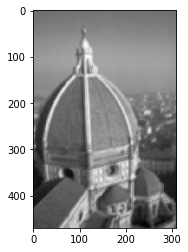

Iteration: 1


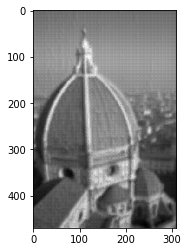

Iteration: 2


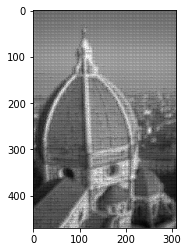

Iteration: 3


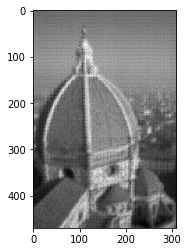

Iteration: 4


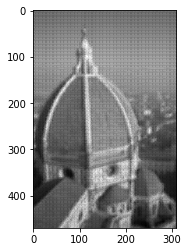

Iteration: 5


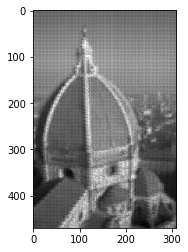

Iteration: 6


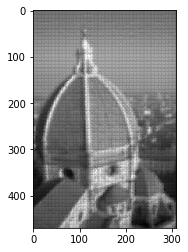

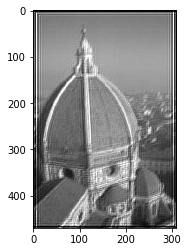

True

In [173]:
blur_img_name = 'blurred'
blur_img_path = 'data/' + blur_img_name
blur_img = cv2.cvtColor(cv2.imread(blur_img_path + '.jpg'), cv2.COLOR_BGRA2GRAY).astype('double') / 255.0
# blur_img = blur_img[::4, ::4] + blur_img[1::4, ::4] + blur_img[::4, 1::4] + blur_img[1::4, 1::4]

print('Original: ')
plt.imshow(blur_img, cmap='gray')
plt.show()

kernel_size   = 5
patch_size    = 7
iters         = 10
start_loc     = (0,0)
blur_strength = 0.4
skip          = (3,3)

deblur_img, kernel = deblur(blur_img, kernel_size=kernel_size, patch_size=patch_size, skip=skip)

output_img = restoration.richardson_lucy(blur_img, kernel)
plt.imshow(output_img, cmap='gray')
plt.show()

deblur_img_path = 'output/' + blur_img_name
cv2.imwrite(deblur_img_path + '.jpg', output_img*255.)


In [ ]:
deblur_img_path = 'output/' + blur_img_name
cv2.imwrite(deblur_img_path + '_deblurred.jpg', deblur_img*255.)
cv2.imwrite(deblur_img_path + '_output.jpg', output_img*255.)

trial_img = cv2.filter2D(output_img, -1, kernel)
plt.imshow(trial_img, cmap='gray')
plt.show()
cv2.imwrite(deblur_img_path + '_trial.jpg', trial_img*255.)